In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
print(Base)
# reflect the tables
Base.prepare(engine, reflect=True)

<class 'sqlalchemy.ext.automap.Base'>


C:\Users\kengt\AppData\Local\Temp\ipykernel_29688\718052373.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table
measurement_table = Base.classes.measurement
station_table = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [10]:
inspector = sqlalchemy.inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent_date = session.query(measurement_table.date).order_by(measurement_table.date.desc()).first()
print(recent_date)

('2017-08-23',)


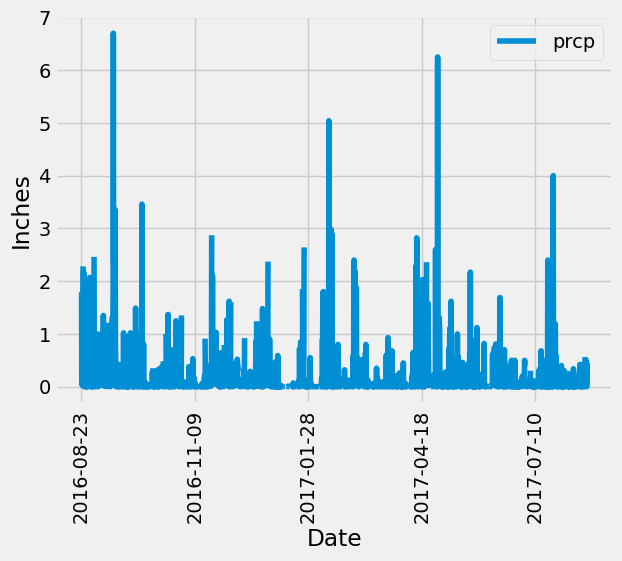

In [31]:
from matplotlib import ticker
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recent_year_query = session.query(measurement_table.date, measurement_table.prcp).filter(measurement_table.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
recent_year_df = pd.DataFrame(recent_year_query, columns=['date', 'prcp'])

# Sort the dataframe by date
recent_year_df = recent_year_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
ax = recent_year_df.plot(x='date', y='prcp', rot=90)
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
recent_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station_table.station).count()

9

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement_table.station, func.count(measurement_table.station)]
station_activity = session.query(*sel).group_by(measurement_table.station).order_by(func.count(measurement_table.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement_table.tobs), func.max(measurement_table.tobs), func.avg(measurement_table.tobs)]
most_active_station = session.query(*sel).filter(measurement_table.station == 'USC00519281').all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

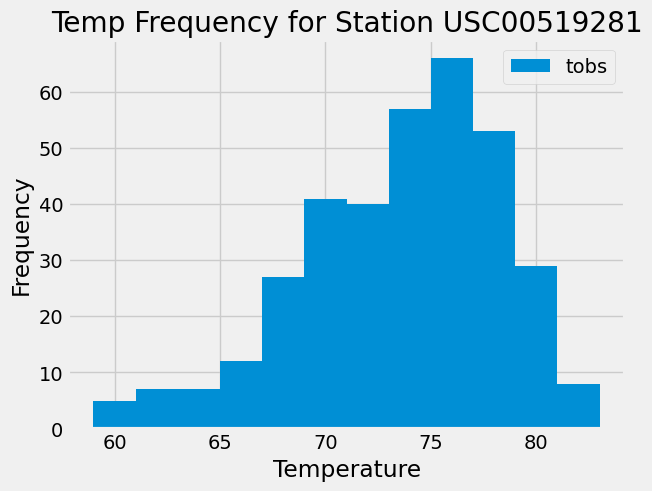

In [62]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps_q = select(measurement_table.tobs).filter(measurement_table.station == 'USC00519281').where(measurement_table.date >= year_ago)
top_station_temps_df = pd.read_sql(year_temps_q, conn)

hist = plt.hist(top_station_temps_df, bins=12)
plt.legend(['tobs'], loc='upper right')
plt.title('Temp Frequency for Station USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()